<a href="https://colab.research.google.com/github/String-ru/AIFFEL_quest_cr/blob/main/Exploration/Quest02/0410_Bad_text_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 회고

손실 그래프를 보면 점점 감소하며 잘 학습한 것으로 생각했는데,

다음과 같은 이상하고 수준 낮은 추상적 요약 결과를 보고...

무엇을 개선해야 할지 고민이 생긴다.

일단 epoch수를 15에서 30-50으로 늘려야 하나 싶지만,

GPU도 제한적이고, 시간도 부족하다. 어떻게 해야 할까..

## --- 추상적 요약 결과 비교 ---

원문: students karnataka get extra marks parents cast votes upcoming assembly elections associated management primary secondary schools announced encouraging marks added 201819 academic year association said casting votes parents visit member schoolsand confirm voted showing indelible ink mark

실제 요약: ktaka students to get extra marks if parents vote in polls

### 예측 요약: artificial artificial artificial artificial artificial artificial artificial artificial artificial artificial there sensex keep keep keep keep play play play


원문: syrian antiaircraft defences monday shot missiles two air bases syrias state media said missiles targeted shayrat air base homs province another base northeast capital damascus comes days us uk france launched air strikes syrian chemical weapons facilities retaliation alleged chemical attack douma

실제 요약: syria shoots down missiles fired at two air bases

### 예측 요약: artificial artificial artificial artificial artificial artificial artificial artificial artificial artificial there sensex keep keep keep keep play play play


원문: dinosaurlike creatures fossil found excavation sunday uttarakhands jaspur small city 110 km nainital fossils hind legs measure around 29 cm tail around cm long found abandoned electricity department land authorities would sending remains dehradunbased wildlife institute india investigation

실제 요약: dinosaurlike animals fossil found in uttarakhand

### 예측 요약: artificial artificial artificial artificial artificial artificial artificial artificial artificial artificial there sensex keep keep keep keep play play play

## Step 1. 데이터 수집하기

Installing summa...
NLTK Version: 3.9.1
TensorFlow Version: 2.18.0
Pandas Version: 2.2.2
Summa Version: 1.2.0


Dataset loaded. Displaying 5 random samples:
                                               headlines  \
58635  Morgan Stanley marks up Flipkart valuation to ...   
11726  Supreme Court modifies time limit for bursting...   
34149  SoftBank may get $4 bn from $2.5 bn investment...   
80603  Blacks 'losing more people to sweets than stre...   
11483  Vicky Donor kiss caused trouble in my marriage...   

                                                    text  
58635  Financial services firm Morgan Stanley has mar...  
11726  The Supreme Court on Tuesday modified the time...  
34149  Japanese conglomerate SoftBank will sell a sub...  
80603  African-American pastors in the US have sued C...  
11483  Actor Ayushmann Khurrana has revealed that his...  

--- 데이터 분석 ---

전체 데이터 개수: 98401

Text 열 null 값 개수: 0
Headlines 열 null 값 개수: 0


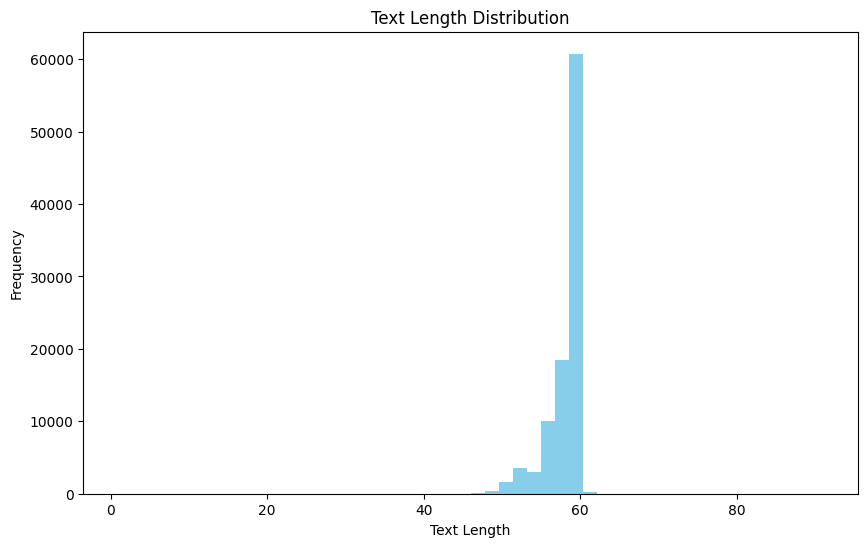

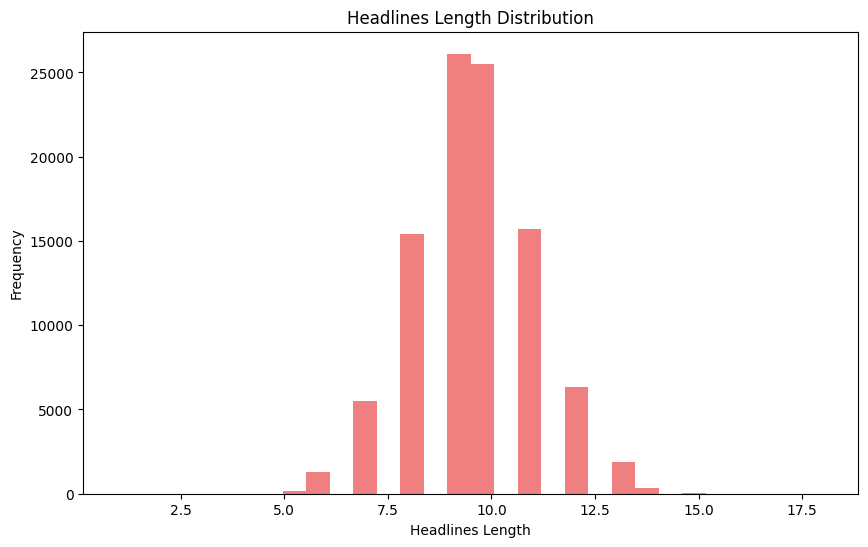


Most common words in Text: [('the', 333652), ('to', 144588), ('a', 137070), ('in', 128523), ('of', 121203), ('and', 106392), ('on', 71346), ('has', 56232), ('for', 55333), ('that', 50298), ('was', 47259), ('is', 40428), ('he', 35032), ('by', 34829), ('said', 33008), ('with', 32692), ('his', 31159), ('after', 28223), ('from', 28024), ('as', 27762)]
Most common words in Headlines: [('to', 31291), ('in', 26194), ('for', 15284), ('of', 13212), ('on', 12543), ('with', 5674), ('a', 5186), ('after', 5154), ('at', 5051), ('from', 4522), ('over', 4395), ('as', 4128), ('by', 4022), ('us', 3954), ('the', 3771), ('india', 3663), ('not', 2983), ('be', 2982), ('is', 2977), ('man', 2968)]


In [1]:
from importlib.metadata import version
import nltk
import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import Counter

# Summa 설치
print("Installing summa...")
!pip install summa
import summa

print("NLTK Version:", nltk.__version__)
print("TensorFlow Version:", tf.__version__)
print("Pandas Version:", pd.__version__)
print("Summa Version:", version('summa'))

# 데이터 다운로드 및 로드
print("\nDownloading the dataset...")
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print("\nDataset loaded. Displaying 5 random samples:")
print(data.sample(5))

# 데이터 분석
print("\n--- 데이터 분석 ---")
print("\n전체 데이터 개수:", len(data))
print("\nText 열 null 값 개수:", data['text'].isnull().sum())
print("Headlines 열 null 값 개수:", data['headlines'].isnull().sum())

# 텍스트 길이 분포 확인
text_len = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(text_len, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 헤드라인 길이 분포 확인
headlines_len = data['headlines'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(headlines_len, bins=30, color='lightcoral')
plt.title('Headlines Length Distribution')
plt.xlabel('Headlines Length')
plt.ylabel('Frequency')
plt.show()

# 가장 자주 등장하는 단어 확인 (Text)
all_text_words = ' '.join(data['text']).lower().split()
text_word_counts = Counter(all_text_words)
most_common_text_words = text_word_counts.most_common(20)
print("\nMost common words in Text:", most_common_text_words)

# 가장 자주 등장하는 단어 확인 (Headlines)
all_headlines_words = ' '.join(data['headlines']).lower().split()
headlines_word_counts = Counter(all_headlines_words)
most_common_headlines_words = headlines_word_counts.most_common(20)
print("Most common words in Headlines:", most_common_headlines_words)

## Step 2. 데이터 전처리하기 (추상적 요약)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


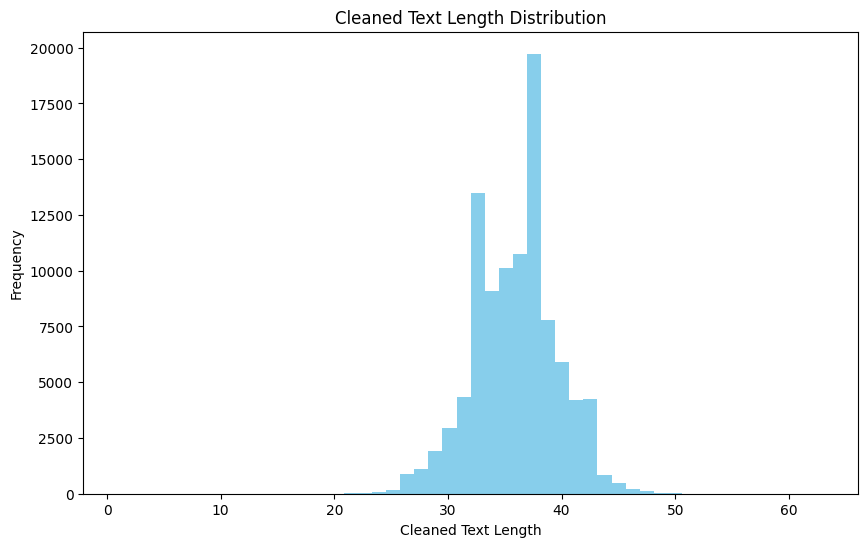

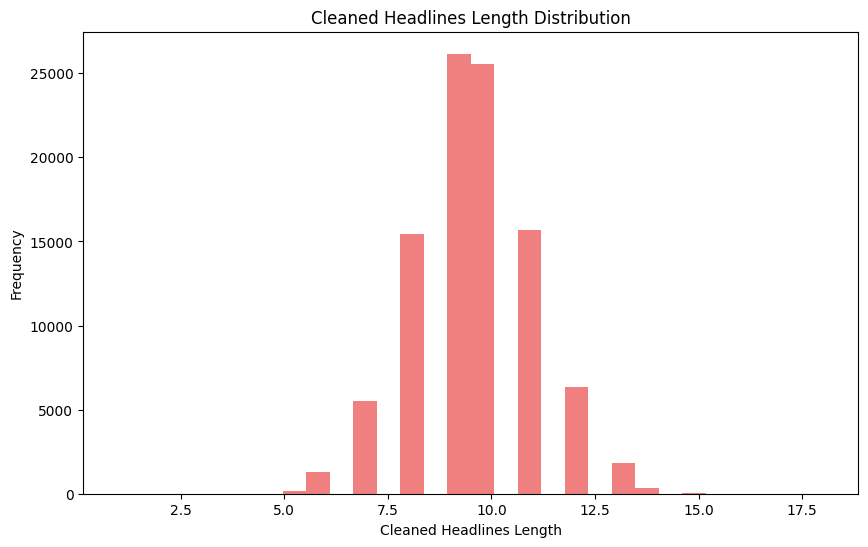


--- 데이터 전처리 완료 ---
Padded Text (Train) shape: (88560, 100)
Padded Text (Validation) shape: (9841, 100)
Padded Decoder Input (Train) shape: (88560, 20)
Padded Decoder Input (Validation) shape: (9841, 20)
Padded Decoder Target (Train) shape: (88560, 20)
Padded Decoder Target (Validation) shape: (9841, 20)
Text Vocabulary Size: 120191
Headlines Vocabulary Size: 44552


In [2]:
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([w for w in text.split() if len(w) > 1 and w not in stop_words]) # 불용어 제거
    return text

def preprocess_headlines(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 전처리 적용
data['cleaned_text'] = data['text'].apply(preprocess_text)
data['cleaned_headlines'] = data['headlines'].apply(preprocess_headlines)

# 빈 값 제거
data.replace('', float('NaN'), inplace=True)
data.dropna(axis=0, inplace=True)

# 텍스트 및 헤드라인 길이 분포 재확인 (전처리 후)
cleaned_text_len = data['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(cleaned_text_len, bins=50, color='skyblue')
plt.title('Cleaned Text Length Distribution')
plt.xlabel('Cleaned Text Length')
plt.ylabel('Frequency')
plt.show()

cleaned_headlines_len = data['cleaned_headlines'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(cleaned_headlines_len, bins=30, color='lightcoral')
plt.title('Cleaned Headlines Length Distribution')
plt.xlabel('Cleaned Headlines Length')
plt.ylabel('Frequency')
plt.show()

# 토큰화 및 패딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len_text = 100
max_len_headlines = 20

# Text 토크나이저
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(data['cleaned_text'])
text_sequences = text_tokenizer.texts_to_sequences(data['cleaned_text'])
padded_text = pad_sequences(text_sequences, maxlen=max_len_text, padding='post')
text_vocab_size = len(text_tokenizer.word_index) + 1

# Headlines 토크나이저
headlines_tokenizer = Tokenizer()
headlines_tokenizer.fit_on_texts(data['cleaned_headlines'])
headlines_sequences = headlines_tokenizer.texts_to_sequences(data['cleaned_headlines'])
padded_headlines = pad_sequences(headlines_sequences, maxlen=max_len_headlines, padding='post')
headlines_vocab_size = len(headlines_tokenizer.word_index) + 1

# 시작/종료 토큰 추가 및 패딩
data['decoder_input'] = data['cleaned_headlines'].apply(lambda x : 'sostoken ' + x + ' eostoken')
decoder_input_sequences = headlines_tokenizer.texts_to_sequences(data['decoder_input'])
padded_decoder_input = pad_sequences(decoder_input_sequences, maxlen=max_len_headlines, padding='post')

decoder_target_sequences = headlines_tokenizer.texts_to_sequences(data['cleaned_headlines'])
padded_decoder_target = pad_sequences(decoder_target_sequences, maxlen=max_len_headlines, padding='post')

# 데이터셋 분리
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(padded_text, padded_decoder_target, test_size=0.1, random_state=42)
x_decoder_train, x_decoder_val, y_decoder_train, y_decoder_val = train_test_split(padded_decoder_input, padded_decoder_target, test_size=0.1, random_state=42)

print("\n--- 데이터 전처리 완료 ---")
print("Padded Text (Train) shape:", x_train.shape)
print("Padded Text (Validation) shape:", x_val.shape)
print("Padded Decoder Input (Train) shape:", x_decoder_train.shape)
print("Padded Decoder Input (Validation) shape:", x_decoder_val.shape)
print("Padded Decoder Target (Train) shape:", y_train.shape)
print("Padded Decoder Target (Validation) shape:", y_val.shape)
print("Text Vocabulary Size:", text_vocab_size)
print("Headlines Vocabulary Size:", headlines_vocab_size)

## Step 3. 어텐션 메커니즘을 사용한 Seq2Seq 모델 설계 및 학습 (추상적 요약)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

K.clear_session()
latent_dim = 256

# 인코더
encoder_inputs = layers.Input(shape=(max_len_text,))
enc_emb = layers.Embedding(text_vocab_size, latent_dim)(encoder_inputs)
encoder_lstm1 = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
encoder_outputs, state_h, state_c = layers.LSTM(latent_dim, return_sequences=True, return_state=True)(encoder_outputs2)

# 디코더
decoder_inputs = layers.Input(shape=(None,))
dec_emb_layer = layers.Embedding(headlines_vocab_size, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = layers.LSTM(latent_dim, return_sequences=True, return_state=True)(dec_emb, initial_state=[state_h, state_c])

# 어텐션 메커니즘
attention_layer = layers.AdditiveAttention(name='attention_layer')
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = layers.Concatenate(axis=-1)([decoder_outputs, attention_outputs])

# 출력층
decoder_dense = layers.TimeDistributed(layers.Dense(headlines_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# 모델 정의
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 256)       │     30,768,896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100, 256),     │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 100, 256),     │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │     11,405,312 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 100, 256),     │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_4[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 512)      │              0 │ lstm_4[0][0],          │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 44552)    │     22,855,176 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,130,888 (256.08 MB)

 Trainable params: 67,130,888 (256.08 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 컴파일 및 학습

Epoch 1/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 289s 194ms/step - loss: 4.0757 - val_loss: 3.0240
Epoch 2/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 310s 194ms/step - loss: 2.8255 - val_loss: 2.3866
Epoch 3/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 321s 193ms/step - loss: 2.2624 - val_loss: 1.9825
Epoch 4/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 323s 194ms/step - loss: 1.8759 - val_loss: 1.6897
Epoch 5/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 268s 193ms/step - loss: 1.5945 - val_loss: 1.4710
Epoch 6/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 323s 194ms/step - loss: 1.3857 - val_loss: 1.3076
Epoch 7/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 268s 194ms/step - loss: 1.2278 - val_loss: 1.1784
Epoch 8/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 322s 194ms/step - loss: 1.1014 - val_loss: 1.0801
Epoch 9/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 267s 193ms/step - loss: 0.9958 - val_loss: 0.9909
Epoch 10/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 324s 194ms/step - loss: 0.9128 - val_loss: 0.9204
Epoch 11/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 321s 193ms/step - loss: 0.8380 - val

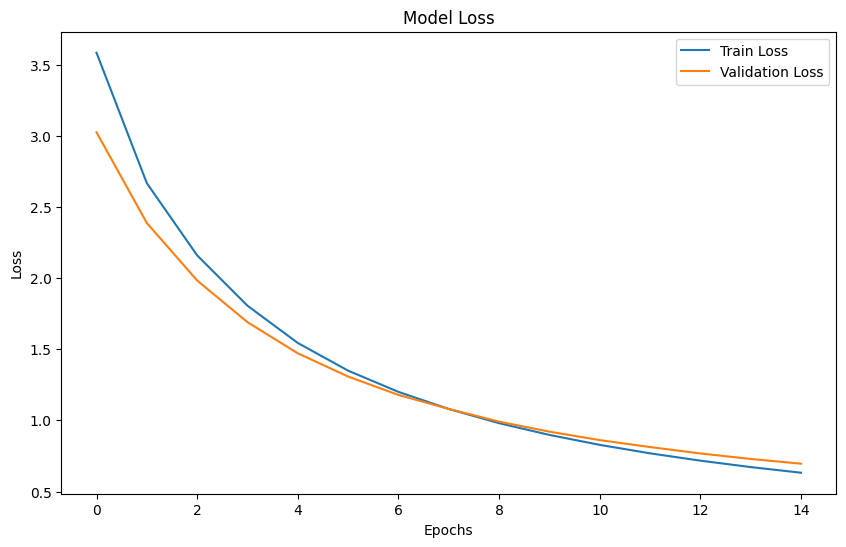

In [4]:
# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit([x_train, x_decoder_train], y_train.reshape((-1, y_train.shape[1], 1)),
                    epochs=15, callbacks=[es], batch_size=64,
                    validation_data=([x_val, x_decoder_val], y_val.reshape((-1, y_val.shape[1], 1))))

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 예측을 위한 모델 재구성
encoder_model = models.Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = layers.Input(shape=(latent_dim,))
decoder_state_input_c = layers.Input(shape=(latent_dim,))
decoder_hidden_state_input = layers.Input(shape=(max_len_text, latent_dim,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
attention_outputs_inf = attention_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_concat_input_inf = layers.Concatenate(axis=-1)([decoder_outputs2, attention_outputs_inf])
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)
decoder_model = models.Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2])

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [5]:
import numpy as np

# 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0:
            temp = temp + text_tokenizer.index_word.get(i, '') + ' '
    return temp.strip()

def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0 and i != headlines_tokenizer.word_index.get('sostoken', 0) and i != headlines_tokenizer.word_index.get('eostoken', 0):
            temp = temp + headlines_tokenizer.index_word.get(i, '') + ' '
    return temp.strip()

# 요약 생성 함수
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = headlines_tokenizer.word_index.get('sostoken', 0)
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = headlines_tokenizer.index_word.get(sampled_token_index)
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (max_len_headlines - 1):
            stop_condition = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c
    return decoded_sentence.strip()

print("\n--- 추상적 요약 결과 비교 ---")
for i in range(10):
    print("원문:", seq2text(x_val[i]))
    print("실제 요약:", seq2summary(y_val[i]))
    print("예측 요약:", decode_sequence(x_val[i].reshape(1, max_len_text)))
    print("\n")


--- 추상적 요약 결과 비교 ---
원문: students karnataka get extra marks parents cast votes upcoming assembly elections associated management primary secondary schools announced encouraging marks added 201819 academic year association said casting votes parents visit member schoolsand confirm voted showing indelible ink mark
실제 요약: ktaka students to get extra marks if parents vote in polls
예측 요약: artificial artificial artificial artificial artificial artificial artificial artificial artificial artificial there sensex keep keep keep keep play play play


원문: syrian antiaircraft defences monday shot missiles two air bases syrias state media said missiles targeted shayrat air base homs province another base northeast capital damascus comes days us uk france launched air strikes syrian chemical weapons facilities retaliation alleged chemical attack douma
실제 요약: syria shoots down missiles fired at two air bases
예측 요약: artificial artificial artificial artificial artificial artificial artificial artifici

## Step 5. Summa을 이용해서 추출적 요약해보기

### 이건 내일 해보자.